<h3>Introducción</h3>
En este Notebook se utilizará el código <a href = "https://github.com/feos-org/feos"> $\mathrm{FeO_s}$</a> v0.3.0 para simular la adsorción de la mezcla binaria hidrógeno-nitrógeno mediante la Teoría del Funcional de la Densidad Clásica. Para esto se necesita tener instalado el código $\mathrm{FeO_s}$, así como, numpy, matplotlib y pandas.

In [1]:
from feos.si import *    
from feos.pcsaft import *
from feos.dft import *  

import numpy as np           
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd

<h3>Hidrógeno-Nitrógeno</h3>
Para ajustar el coeficiente de interacción binaria se utilizan los datos de equilibrio extraídos de <a href = "https://www.sciencedirect.com/science/article/abs/pii/0021961478900836?via%3Dihub"> Street y Calado</a>.

In [2]:
df = pd.read_csv('./Binary_comp_N2.csv',header= None)

Temp1 = df[0]
Pres1 = df[1]*10 # Presion en bar
xliq1 = df[2] # fraccion molar liquida
xvap1 = df[3] # fraccion molar vapor
Temp2 = df[4]
Pres2 = df[5]*10 # Presion en bar
xliq2 = df[6] # fraccion molar liquida
xvap2 = df[7] # fraccion molar vapor
Temp3 = df[8]
Pres3 = df[9]*10 # Presion en bar
xliq3 = df[10] # fraccion molar liquida
xvap3 = df[11] # fraccion molar vapor
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,90.79,1.86,0.034,0.685,100,1.45,0.018,0.338,110.3,3.17,0.055,0.361
1,90.79,2.48,0.047,0.748,100,2.07,0.031,0.490,110.3,3.90,0.080,0.426
2,90.79,3.45,0.072,0.794,100,2.96,0.056,0.587,110.3,4.69,0.107,0.463
3,90.79,4.55,0.099,0.816,100,4.14,0.090,0.659,110.3,5.07,0.125,0.477
4,90.79,6.07,0.144,0.823,100,5.34,0.128,0.682,110.3,5.72,0.153,0.489


Debido a que en los Notebooks anteriores se mostró como determinar los parámetros SAFT, en este Notebook se utilizan directamente. Lo primero es definir los compuestos y el parámetro binario,de acuerdo a lo mostrado <a href = "https://github.com/feos-org/feos/blob/main/examples/pcsaft_working_with_parameters.ipynb"> aquí</a>.

In [3]:
hidrog = PureRecord(identifier=Identifier(name='Hidrógeno',iupac_name='Hidrógeno',), 
         molarweight=2.016, model_record=PcSaftRecord(m=1, sigma=3.105, epsilon_k=28.25))
nitrog = PureRecord(identifier=Identifier(name='Nitrógeno',iupac_name='Nitrógeno'), 
          molarweight=28.01, model_record=PcSaftRecord(m=1.21, sigma=3.335, epsilon_k=90.7))
parameters = PcSaftParameters.new_binary([hidrog, nitrog], binary_record=-0.03)
func = HelmholtzEnergyFunctional.pcsaft(parameters, FMTVersion.WhiteBear)
print(parameters.k_ij)
parameters

[[ 0.   -0.03]
 [-0.03  0.  ]]


|component|molarweight|$m$|$\sigma$|$\varepsilon$|$\mu$|$Q$|$\kappa_{AB}$|$\varepsilon_{AB}$|$N_A$|$N_B$|
|-|-|-|-|-|-|-|-|-|-|-|
|Hidrógeno|2.016|1|3.105|28.25|0|0|0|0|1|1|
|Nitrógeno|28.01|1.21|3.335|90.7|0|0|0|0|1|1|

Una vez definido el funcional y los compuestos, se determinan los diagramas de equilibrio líquido-vapor para la
mezcla binaria. Para esto, en "pcsaft" se emplea la función `EquationOfState.pcsaft` para iniciar la EOS PC-SAFT con los parámetros de los compuestos anteriores. Luego, en "diagrama" se calculan los diagramas de fase binarios iterando puntos de burbuja y rocío con la función `PhaseDiagram.binary_vle`, para esto se explicita la EOS a utilizar (pcsaft), la temperatura y la cantidad de puntos a calcular.

En "diagrama" se almacenan las fracciones molares y las presiones de la fase liquida y vapor por separadas. La fracción molar del vapor se obtiene con `diagrama.vapor.molefracs` y la presión con `diagrama.vapor.pressure`, mientras que para la fase líquida se obtienen con `diagrama.liquid.molefracs` y `diagrama.liquid.pressure`.

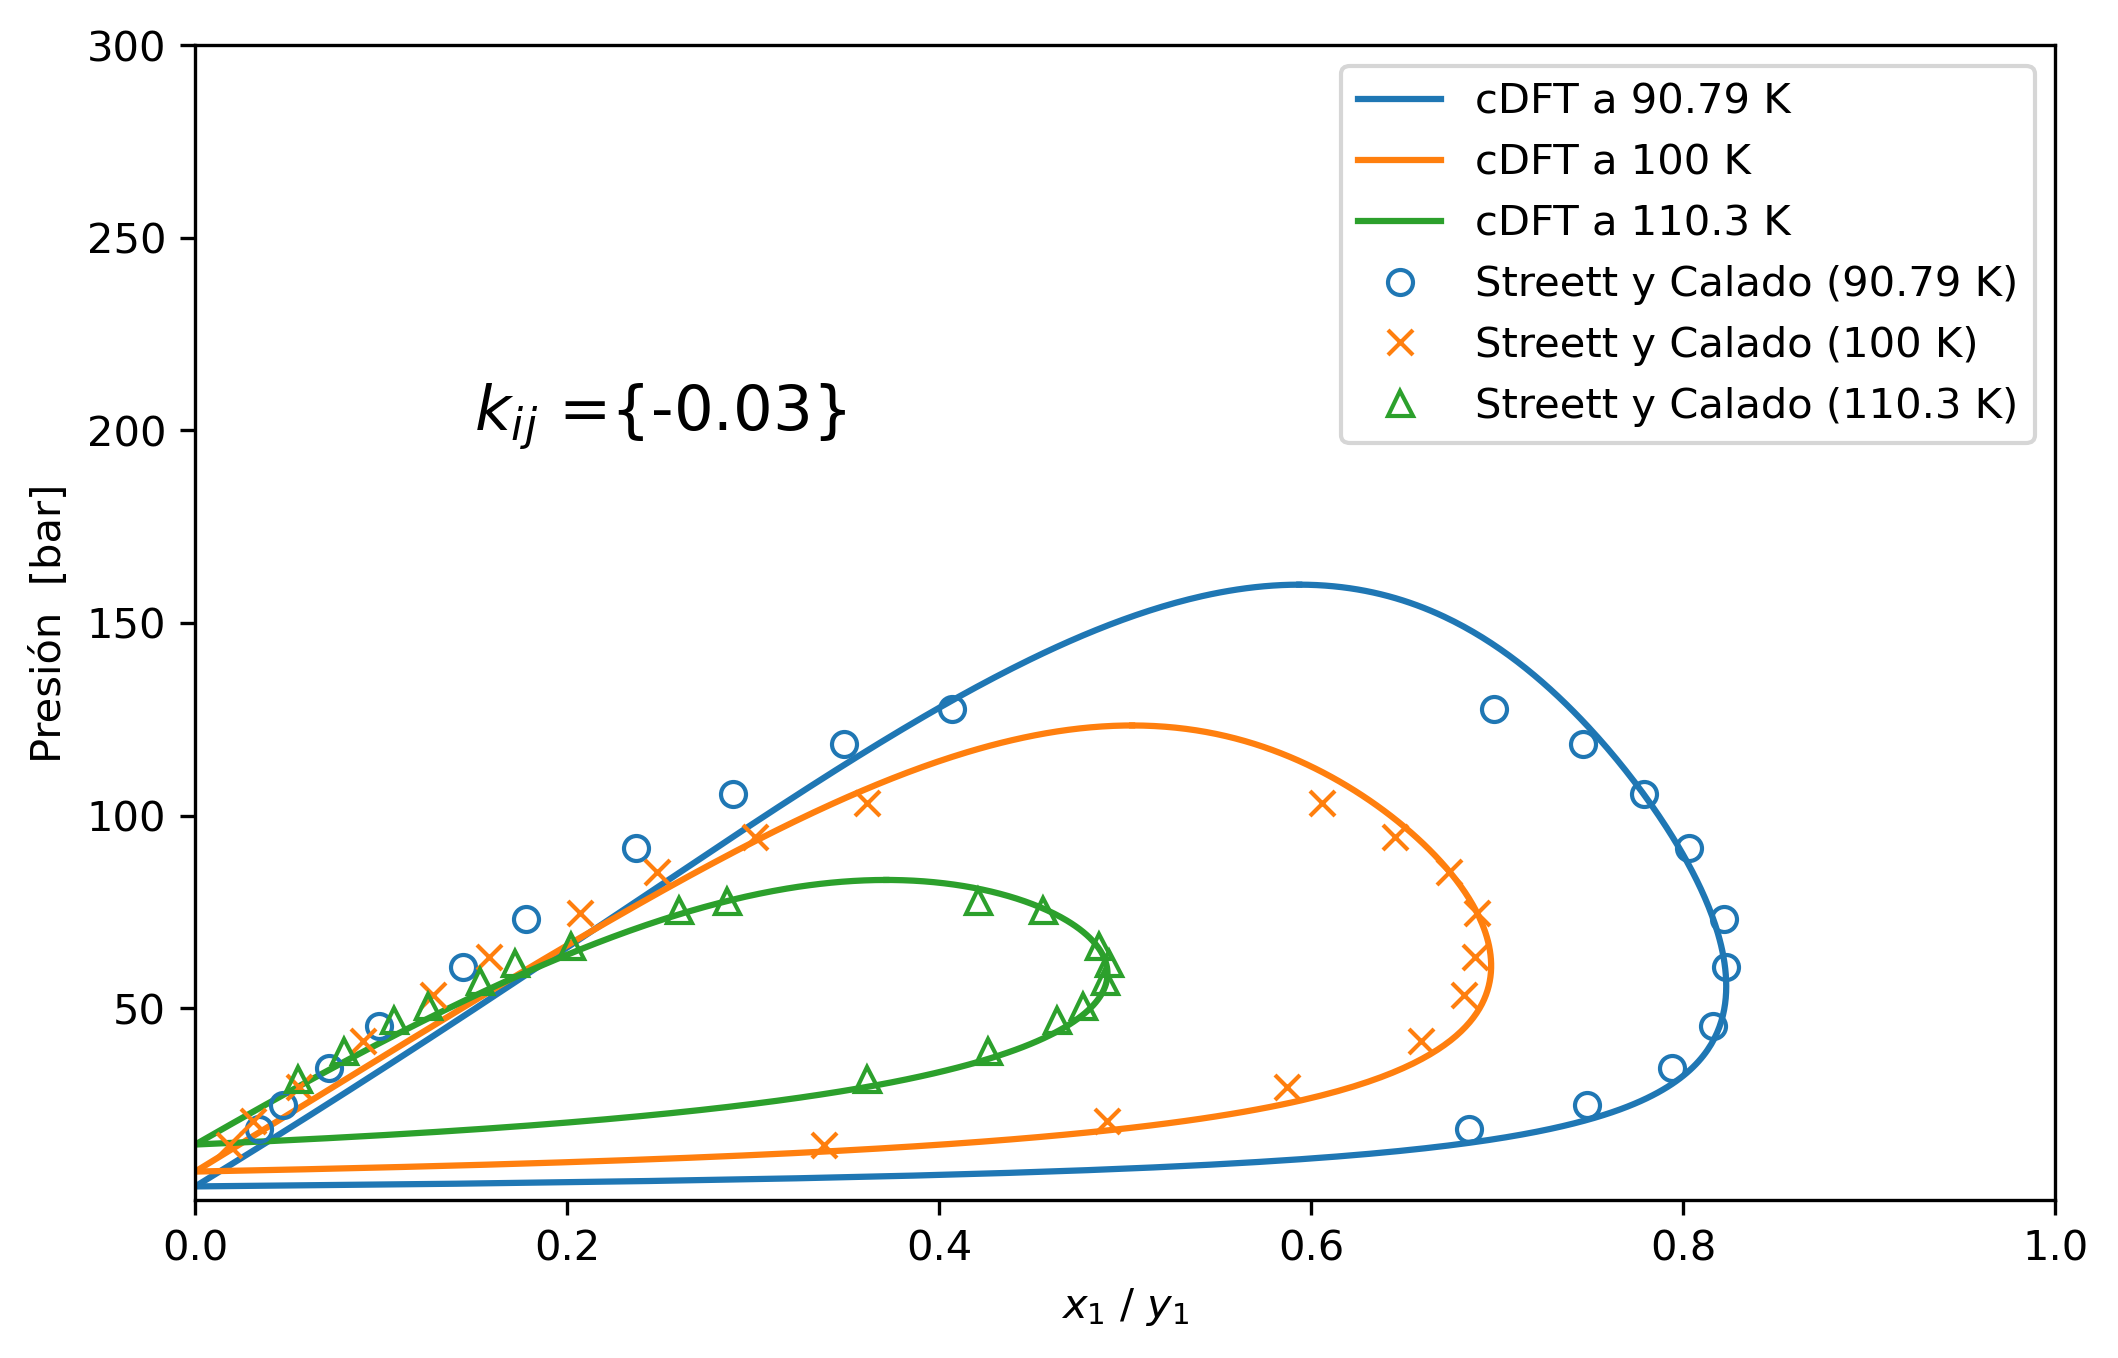

In [4]:
from feos.eos import *
figure(figsize=(8, 5), dpi=300)

pcsaft = EquationOfState.pcsaft(parameters)
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "mediumpurple"]
naux = 0
for i in [90.79, 100, 110.3]:
    phase_diagram = PhaseDiagram.binary_vle(pcsaft, i * KELVIN, npoints=251)   
    plt.plot(phase_diagram.vapor.molefracs[:, 0],phase_diagram.vapor.pressure / BAR, color=colors[naux],
            label="cDFT a {}".format(i * KELVIN))
    plt.plot(phase_diagram.liquid.molefracs[:, 0],phase_diagram.liquid.pressure / BAR, color=colors[naux])
    naux+=1

plt.plot(xliq1,Pres1,marker="o",linestyle="None",mfc="None",color=colors[0],label="Streett y Calado (90.79 K)")
plt.plot(xvap1,Pres1,marker="o",linestyle="None",mfc="None",color=colors[0])

plt.plot(xliq2,Pres2,marker="x",linestyle="None",mfc="None",color=colors[1],label="Streett y Calado (100 K)")
plt.plot(xvap2,Pres2,marker="x",linestyle="None",mfc="None",color=colors[1])

plt.plot(xliq3,Pres3,marker="^",linestyle="None",mfc="None",color=colors[2],label="Streett y Calado (110.3 K)")
plt.plot(xvap3,Pres3,marker="^",linestyle="None",mfc="None",color=colors[2])

pot={parameters.k_ij[0][1]}
eq1 = (r"$k_i$$_j$ ={}".format(pot))
plt.text(0.15, 200, eq1, color="k", fontsize=15) #horizontal, vertical

plt.legend(loc="best", numpoints=1) 
#plt.title(f'Binary phase diagram para Hidrogeno (1), Nitrogeno (2)')
plt.ylabel(r'Presión  [bar]')
plt.xlabel(r"$x_1$ / $y_1$")
plt.xlim(0, 1)
plt.ylim(0.2, 300);

Para obtener los perfiles de densidad de la mezcla a diferentes presiones se usa un procedimiento similar al descrito en Notebooks anteriores, pero agregando las fracciones molares en "bulk". En "moles" se especifica las fracciones de cada compuesto en el orden en que se definieron, es decir, 0.9 para hidrógeno y 0.1 para nitrógeno.

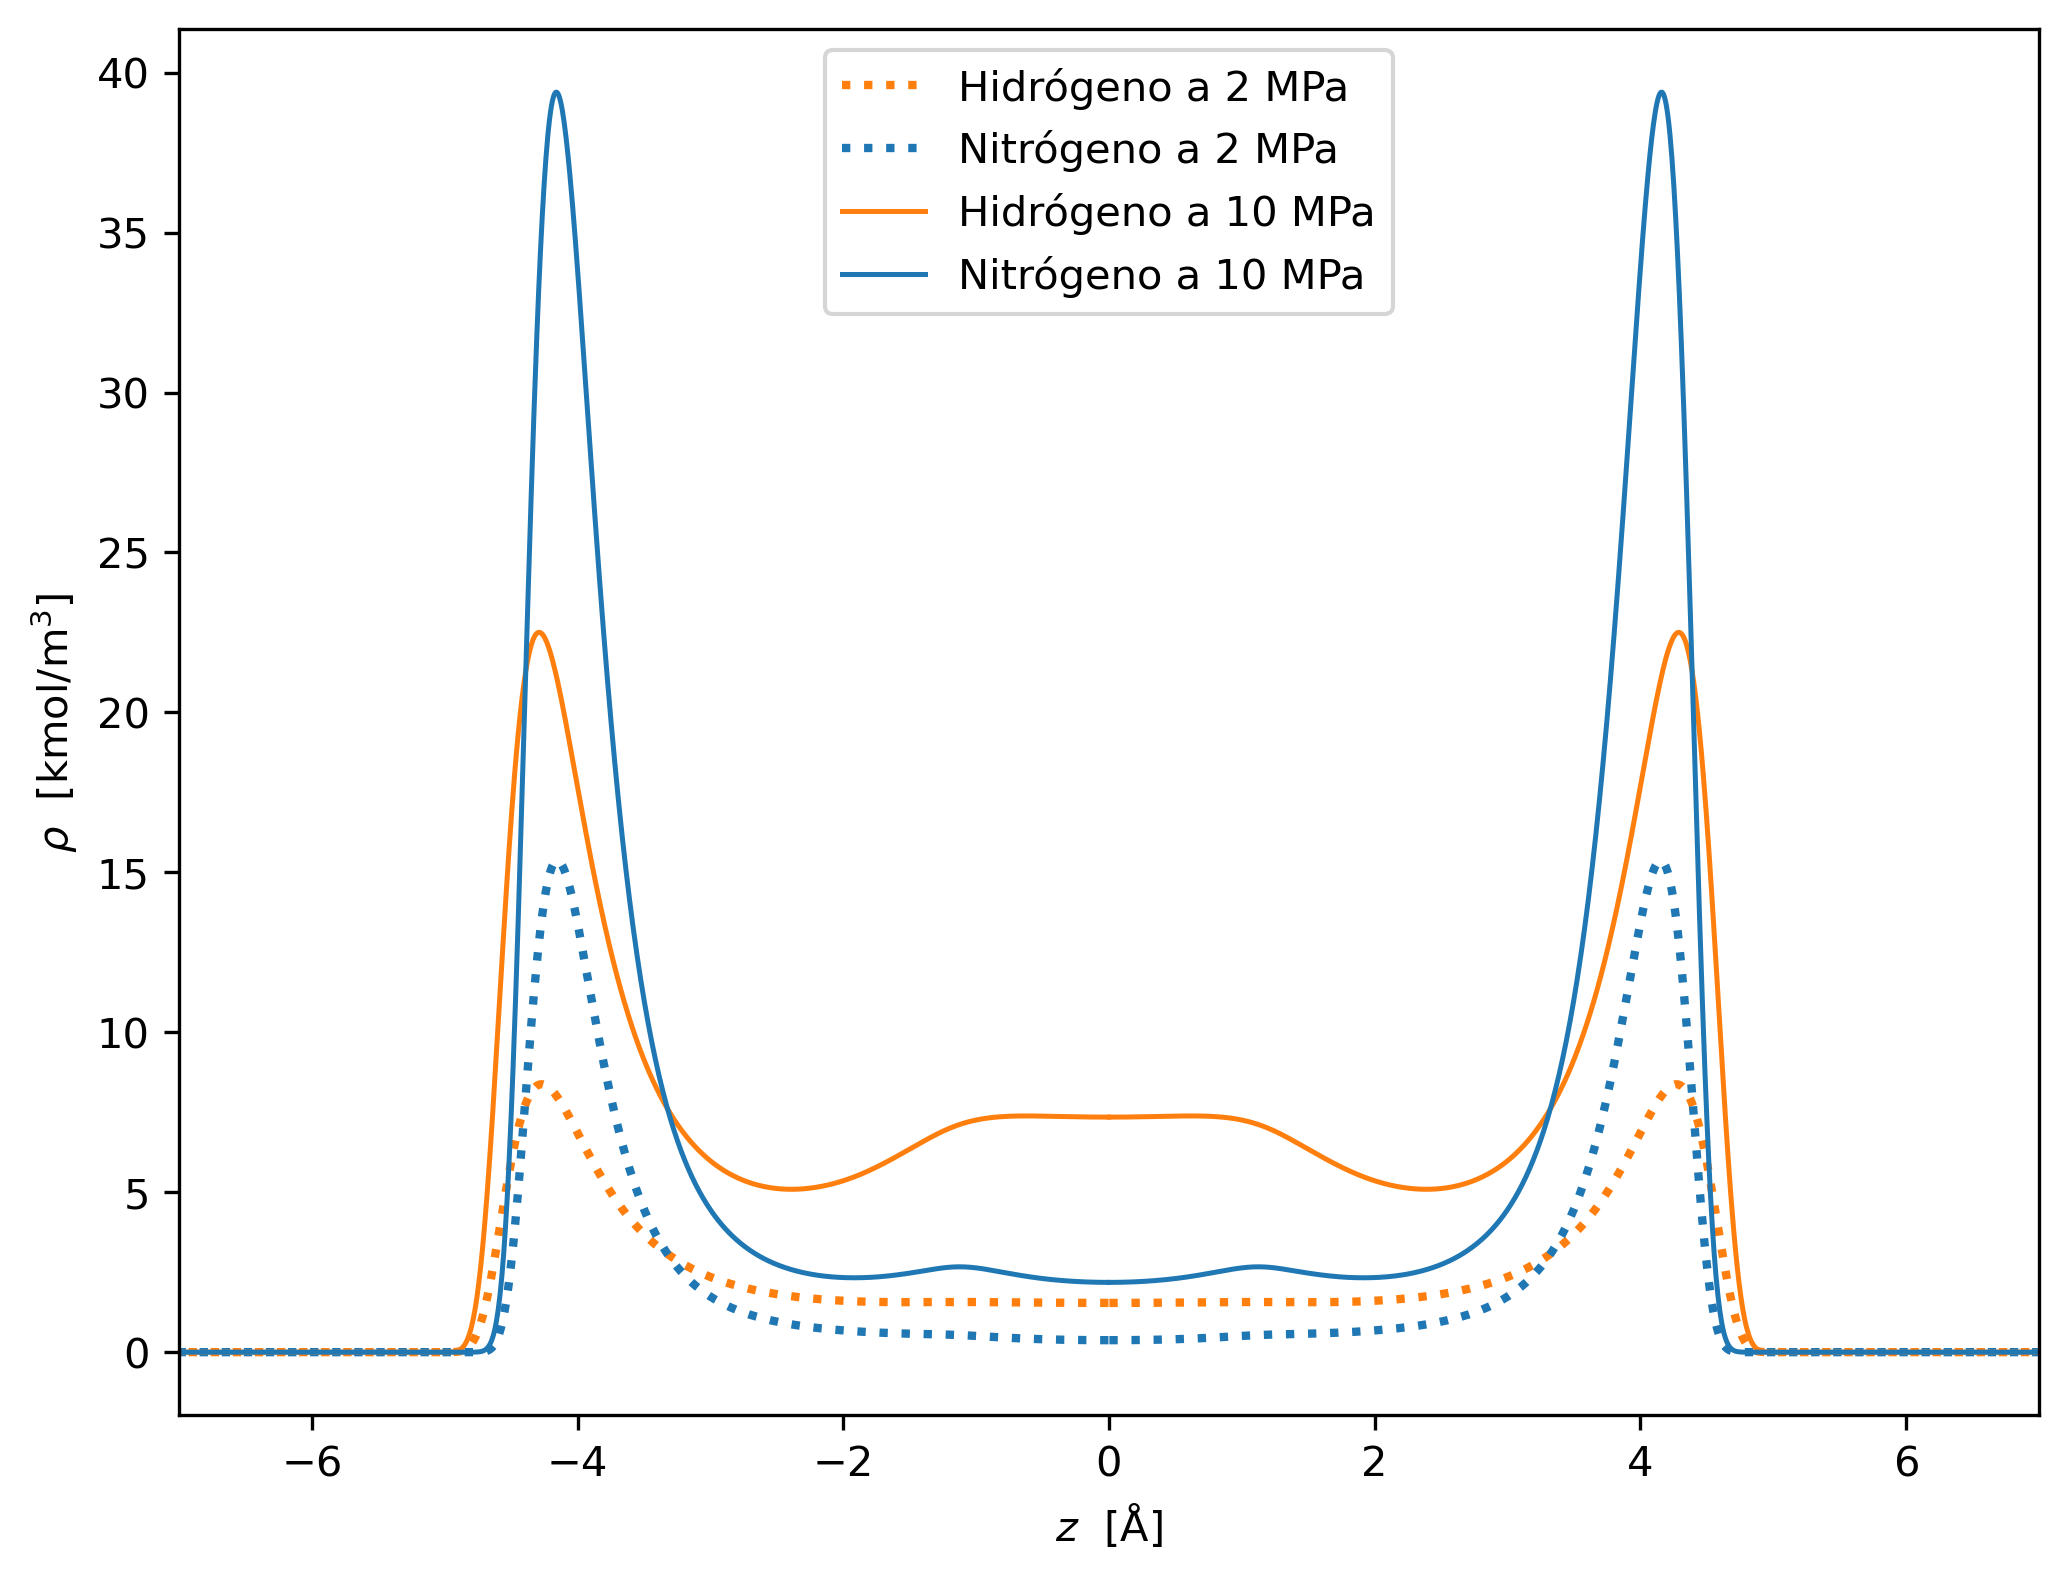

In [5]:
from feos.dft import *
figure(figsize=(8, 6), dpi=300)

temp = 210*KELVIN
psize= 15*ANGSTROM
moles= np.array([0.90, 0.1])
solver = DFTSolver().picard_iteration(tol=1e-5, beta=0.05).anderson_mixing()
potential = ExternalPotential.Steele(3.40, 28.0, 0.114)  # https://doi.org/10.1021/la803666t

colors=['tab:orange','tab:blue','tab:orange','tab:blue']
line=[":",":","-","-"]
width=[2,2,1.2,1.2]
naux = 0

for i in [20,100]:
    bulk = State(func, temp, pressure=i*BAR,molefracs=moles)
    porex = Pore1D(Geometry.Cartesian, psize, potential).initialize(bulk).solve(solver)
    for j in [0,1]:
        plt.plot(porex.z/(ANGSTROM), (porex.density*(METER**3/MOL)/1000)[j].T,
                 color = colors[naux], linestyle=line[naux], linewidth=width[naux],
                 label="{} a {}".format(parameters.pure_records[j].identifier.iupac_name,i * BAR))
        plt.plot(-porex.z/(ANGSTROM), (porex.density*(METER**3/MOL)/1000)[j].T,
                 color=colors[naux], linestyle=line[naux], linewidth=width[naux])
        naux+=1
              
plt.legend(loc="best", numpoints=1)  
plt.xlabel(r"$z$  [Å]")
plt.ylabel(r"$\rho$  [kmol/m$^3$]")
plt.xlim(-7, 7)
#plt.suptitle(F'Perfiles de densidad para {(moles[0]*100):.0f}% H2 y {(moles[1]*100):.0f}% N2 a {temp} en un poro de {psize}')
plt.show()

Una vez obtenidos los perfiles de densidad, se determinaron las isotermas de adsorción. El procedimiento utilizado, también se encuentra definido en Notebooks anteriores. La diferencia radica en incluir las fracciones molares de la mezcla a la isoterma, esto se hace especificando `molefracs=moles` en "isotherm".

Además las contribuciones de cada compuesto a la adsorción se separan mediante `isotherm.adsorption` y se grafican por separado.

CPU times: user 30.5 s, sys: 107 ms, total: 30.6 s
Wall time: 30.6 s


Text(0, 0.5, '$N$  $[\\mu$mol/m$^2]$')

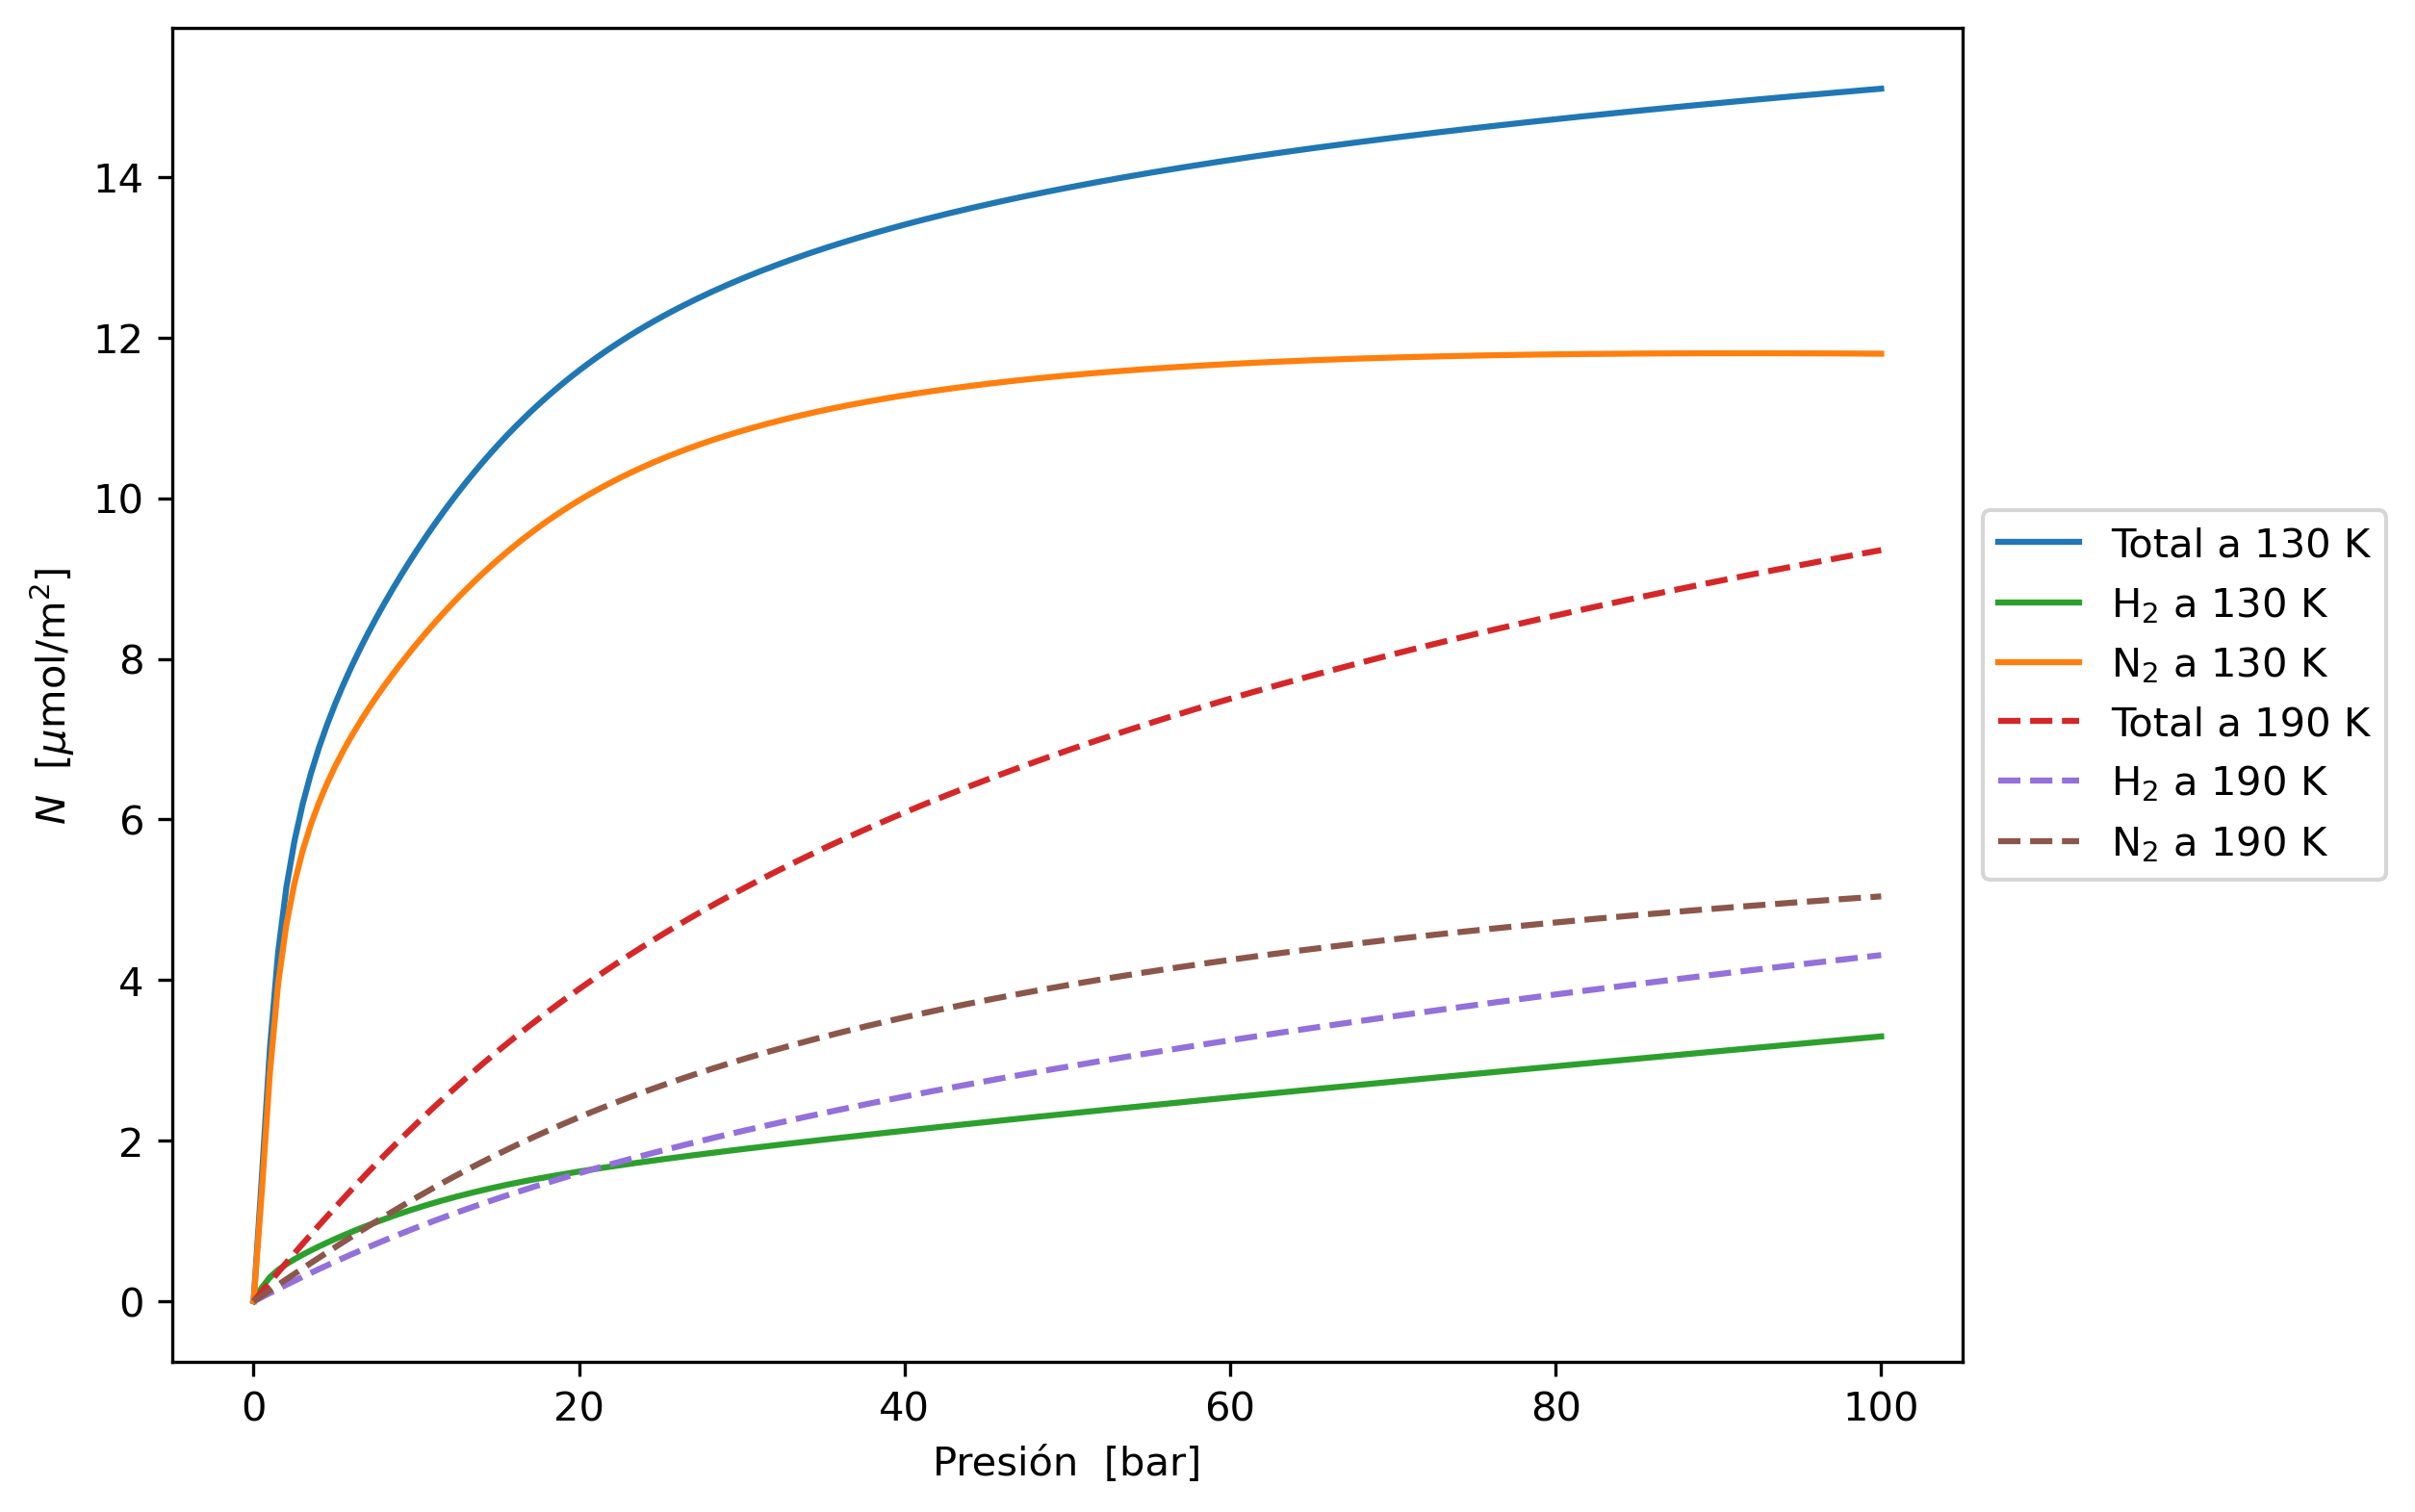

In [6]:
%%time
figure(figsize=(8, 6), dpi=300)

pore_siz = 15 * ANGSTROM
moles= np.array([0.9, 0.1])
potential = ExternalPotential.Steele(3.40, 28.0, 0.114)  # https://doi.org/10.1021/la803666t
pore = Pore1D(geometry=Geometry.Cartesian, pore_size = pore_siz, potential = potential)

colorH = ["tab:green", "mediumpurple"]
colorT = ['tab:blue','tab:red']
colorN = ["tab:orange", "tab:brown"]
line   = ["solid","--"]
width  = [1.5,1.5]
naux2  = 0
for i in [130, 190]:
    isotherm  = Adsorption1D.adsorption_isotherm(func, temperature = (i * KELVIN), 
                pressure = SIArray1.linspace(1.0e-3 * BAR, 100*BAR, 200), pore = pore, molefracs=moles)
    p         = isotherm.pressure / BAR
    total_ads = isotherm.total_adsorption / (MICRO * MOL / METER**2)
    isot      = isotherm.adsorption/ (MICRO * MOL / METER**2)
    plt.plot(p, total_ads, color = colorT[naux2], linestyle=line[naux2], linewidth=width[naux2],
                 label = "Total a {}".format(i * KELVIN))
    plt.plot(p, isot[0], color = colorH[naux2], linestyle=line[naux2], linewidth=width[naux2],
                 label = "H$_2$ a {}".format(i * KELVIN))
    plt.plot(p, isot[1], color = colorN[naux2], linestyle=line[naux2], linewidth=width[naux2],
                 label = "N$_2$ a {}".format(i * KELVIN))
    naux2+=1

plt.legend(bbox_to_anchor=(1, 0.5), loc='center left', ncol=1) 
plt.xlabel(r'Presión  [bar]')
plt.ylabel(r'$N$  $[\mu$mol/m$^2]$')
#plt.suptitle(F'Isotermas de adsorción para {(moles[0]*100):.0f}% H2 y {(moles[1]*100):.0f}% CH4 en un poro de {pore_siz}')

También, se calculan isotermas siguiendo el mismo procedimiento anterior, pero variando la composicion de la mezcla a una temperatura fija.

CPU times: user 4min, sys: 372 ms, total: 4min
Wall time: 4min 2s


Text(0.5, 0.98, 'Isotermas de adsorción para H$_2$ y CO$_2$ a 125 K en un poro de 2 nm')

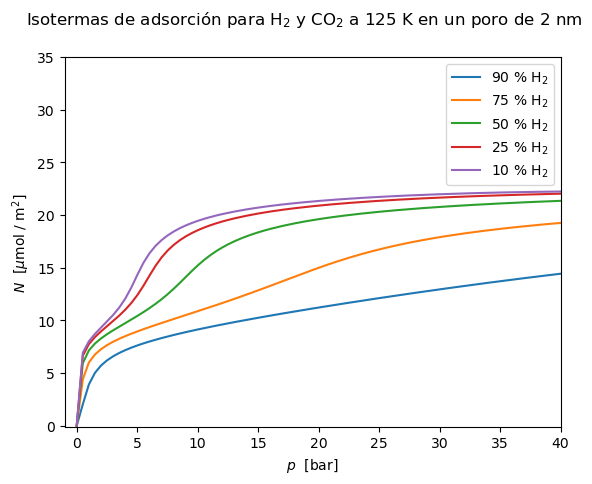

In [7]:
%%time
moles= np.array([0.9, 0.1])
tempet=125
pore_siz = 20 * ANGSTROM

potential = ExternalPotential.Steele(3.40, 28.0, 0.114)  # https://doi.org/10.1021/la803666t
pore = Pore1D(geometry=Geometry.Cartesian, pore_size = pore_siz, potential = potential)

for i in [0.9,0.75,0.5,0.25,0.1]:
    isotherm = Adsorption1D.adsorption_isotherm(func, temperature = (tempet * KELVIN), 
            pressure = SIArray1.linspace(1.0e-3 * BAR, 250*BAR, 500), pore = pore, molefracs=np.array([i, 1-i]))
    p = isotherm.pressure / BAR
    total_adsorption = isotherm.total_adsorption / (MICRO * MOL / METER**2)
    plt.plot(p, total_adsorption, label="{:.0f} % H$_2$".format(i*100))

plt.legend(loc="best", numpoints=1)    
plt.xlim(-1, 40)
plt.ylim(-0.1, 35)
plt.xlabel(r'$p$  [bar]')
plt.ylabel(r'$N$  $[\mu$mol / m$^2]$')
plt.suptitle(F'Isotermas de adsorción para H$_2$ y CO$_2$ a {tempet} K en un poro de {pore_siz}')

Finalmente, se muestra el perfil de densidad de la interface liquido-vapor para la mezcla binaria. Para esto en "vle", se crea el estado liquido y vapor en equilibrio de la mezcla con `PhaseEquilibrium.tp_flash` especificando el funcional con la ecuacion de estado a utilizar (func), la temperatura (Tempr), la presion (Presr) y la composicion molar (Moler)

Luego, en "interface" se resuelve la interface plana con una tangente hiperbolica mediante la funcion `PlanarInterface.from_tanh`. En esta funcion se debe definir el equilibrio de las fases (vle), la cantidad de puntos a calcular (Puntos), el ancho del dominio de cálculo (Long) y una estimación para la temperatura critica del sistema (Tempr)

En "interface" se almacenan las densidades y la posición (z) de los compuestos. La posición se obtiene con "interface.z" y la densidad con "interface.density", para graficar ambas hay que volverlas adimensionales, por lo que se debe dividir por sus unidades correspondientes.

Text(0.5, 0.98, 'Perfiles para 90% H$_2$ y 10% N$_2$ a 77 K y 2 MPa')

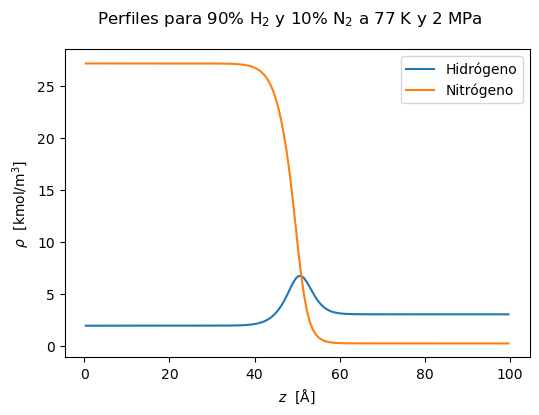

In [8]:
from feos.dft import *
Tempr = 77 * KELVIN
Presr = 20 * BAR
Moler = ([0.9, 0.1])

Long  = 100 * ANGSTROM
Puntos= 150

solver = DFTSolver().picard_iteration(tol=1e-5, beta=0.05).anderson_mixing()
vle = PhaseEquilibrium.tp_flash(func,Tempr,Presr,np.array(Moler) * MOL)
interface = PlanarInterface.from_tanh(vle, Puntos, Long, Tempr).solve(solver)

plt.figure(figsize=(6, 4))
plt.plot(interface.z / ANGSTROM, (interface.density / (KILO * MOL / METER**3))[0], label="{}".format(parameters.pure_records[0].identifier.name))
plt.plot(interface.z / ANGSTROM, (interface.density / (KILO * MOL / METER**3))[1], label="{}".format(parameters.pure_records[1].identifier.name))
plt.legend(loc="best", numpoints=1)  
plt.xlabel(r"$z$  [Å]")
plt.ylabel(r"$\rho$  [kmol/m$^3$]")
#plt.ylim(0, 5)
#plt.xlim(0, 100)
plt.suptitle(F'Perfiles para {(Moler[0]*100):.0f}% H$_2$ y {(Moler[1]*100):.0f}% N$_2$ a {Tempr} y {Presr}')